<img src="../images/airplane-symbol.jpg" style="float: left; margin: 20px;" width="50" height="50"> 
#  Predicting Flight Delays (<i>a Proof-of-Concept</i>)

Author: Solomon Heng

---

# (5) Exploratory Data Analysis

**_While we eventually intend to build a model for every single route, we will be conducting EDA on the entire KATL dataset just to understand our dataset better_**

## Processes covered in this notebook:
1. [Importing dataset](#(1)-Importing-dataset)
2. [Creating features which would be relevant for EDA and modeling](#(2)-Creating-features-which-would-be-relevant-for-EDA-and-modeling)
3. [EDA](#(3)-EDA)
4. [Dropping-anomalies](#(4)-Dropping-anomalies)
5. [Exporting the dataset](#(5)-Exporting-the-dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set()

---
### (1) Importing dataset

---

In [2]:
df = pd.read_csv('../datasets/combined_data.csv')

In [3]:
pd.set_option('display.max_columns', 100)
df.head()

,DATETIME,DAY_OF_WEEK,SCHEDULED_ARRIVAL_YEAR,SCHEDULED_ARRIVAL_MONTH,SCHEDULED_ARRIVAL_DAY,SCHEDULED_ARRIVAL_HOUR,SCHEDULED_ARRIVAL_MINS,AIRLINE_CODE,AIRLINE_NAME,ORIGIN_AIRPORT,ORIGIN_AIRPORT_NAME,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_AIRPORT_LATITUDE,ORIGIN_AIRPORT_LONGITUDE,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,WHEELS_OFF,SCHEDULED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,LATE_AIRCRAFT_DELAY,QNH,dew_point,lightning,low_intensity,rain,shower,snow,squall,temp,thunderyshower,vicinity,visibility,winddir,windspd,windgust
0,2015-01-01,4,2015,1,1,7,11,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,30,33.0,3.0,45.0,221.0,186.0,1747,651.0,711,656.0,-15.0,0.0,30.36,0.0,0,0,0,0,0,0,4.0,0,0,10.0,0.0,0.0,0
1,2015-01-01,4,2015,1,1,14,0,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,715,712.0,-3.0,726.0,225.0,191.0,1747,1337.0,1400,1342.0,-18.0,0.0,30.31,-3.0,0,0,0,0,0,0,1.0,0,0,10.0,330.0,7.0,0
2,2015-01-01,4,2015,1,1,17,58,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,1115,1116.0,1.0,1131.0,223.0,191.0,1747,1742.0,1758,1747.0,-11.0,0.0,30.33,-3.0,0,0,0,0,0,0,0.0,0,0,10.0,0.0,0.0,0
3,2015-01-01,4,2015,1,1,20,33,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,1345,1353.0,8.0,1406.0,228.0,194.0,1747,2020.0,2033,2023.0,-10.0,0.0,30.36,-3.0,0,0,0,0,0,0,8.0,0,0,10.0,310.0,4.0,0
4,2015-01-01,4,2015,1,1,22,0,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,1519,1518.0,-1.0,1530.0,221.0,190.0,1747,2140.0,2200,2144.0,-16.0,0.0,30.28,-6.0,0,0,0,0,0,0,12.0,0,0,10.0,260.0,3.0,0


In [4]:
df.shape

(341900, 44)

---
### (2) Creating features which would be relevant for EDA and modeling

---

#### (i) Creating arrival delay/no delay feature

The Federal Aviation Administration (FAA) considers a flight to be delayed when it is 15 minutes later than its scheduled time.

In [5]:
df['ARRIVAL_DELAY/NO_DELAY'] = [1 if i>15 else 0 for i in df['ARRIVAL_DELAY']]

In [6]:
# Creating table to understand number of arrivals scheduled to land every hour

df['count'] = [1 for i in df['DATETIME']] # Creating helper column to help us agggregate count later on

landing_count = df.groupby(['SCHEDULED_ARRIVAL_MONTH', 'SCHEDULED_ARRIVAL_DAY', 'SCHEDULED_ARRIVAL_HOUR'])[['count']].sum()
landing_count.columns = ['NUM_ARR_IN_HOUR']

#### (ii) Creating a feature which helps us understand the competition for landing slots

If we take the arrival counts in the hour for every flight, we are assuming that it will affect the flight regardless of what time the flight arrives. _Meaning to say, if the flight arrives at the 59th minute of the hour, the count which the flight will experience is still the same even though technically all the counts of arrivals would have already landed before it in the hour._

Now we can take the count of arrivals scheduled to land 1 hour prior to flight OR take the count 1 hour before & prior to the flights actual scheduled arrival time. But in reality, what the actual flight experiences would be very different (due to delays, early arrivals, etc) and also manipulating the data for the required feature would be a complex process.

Since our purpose of this feature is to have a rough sense of how long or how many other aircrafts are projected to be competing with the flight for landing queue, we have decided to keep it simple by averaging the 3 hour window (h-1 to h+1) of the count of arrivals.

In [7]:
# Creating 3 more features: 
# number of arrivals in the hour before, number of arrivals the hour after & number of arrivals hour before till hour after

landing_count['NUM_ARR_IN_HOUR+1'] = landing_count['NUM_ARR_IN_HOUR'].shift(-1)
landing_count['NUM_ARR_IN_HOUR-1'] = landing_count['NUM_ARR_IN_HOUR'].shift(1)

# Filling in the nulls at the start and back by back & forward propagating respectively
landing_count['NUM_ARR_IN_HOUR+1'].fillna(method='ffill', inplace=True)
landing_count['NUM_ARR_IN_HOUR-1'].fillna(method='bfill', inplace=True)

# Getting the average count of arrivals in the 3 hour window
landing_count['NUM_ARR_3HOUR'] = landing_count['NUM_ARR_IN_HOUR'] + landing_count['NUM_ARR_IN_HOUR+1'] + landing_count['NUM_ARR_IN_HOUR-1']
landing_count['NUM_ARR_AVG_3HOUR'] = landing_count['NUM_ARR_3HOUR']/3

In [8]:
landing_count.head()

NUM_ARR_IN_HOUR  \
SCHEDULED_ARRIVAL_MONTH SCHEDULED_ARRIVAL_DAY SCHEDULED_ARRIVAL_HOUR                    
1                       1                     5                                     5   
                                              6                                     5   
                                              7                                    15   
                                              8                                    40   
                                              9                                    39   

                                                                      NUM_ARR_IN_HOUR+1  \
SCHEDULED_ARRIVAL_MONTH SCHEDULED_ARRIVAL_DAY SCHEDULED_ARRIVAL_HOUR                      
1                       1                     5                                     5.0   
                                              6                                    15.0   
                                              7                                    40.0   
                                              8                                    39.0   
                                              9                                    38.0   

                                                                      NUM_ARR_IN_HOUR-1  \
SCHEDULED_ARRIVAL_MONTH SCHEDULED_ARRIVAL_DAY SCHEDULED_ARRIVAL_HOUR                      
1                       1                     5                                     5.0   
                                              6                                     5.0   
                                              7                                     5.0   
                                              8                                    15.0   
                                              9                                    40.0   

                                                                      NUM_ARR_3HOUR  \
SCHEDULED_ARRIVAL_MONTH SCHEDULED_ARRIVAL_DAY SCHEDULED_ARRIVAL_HOUR                  
1                       1                     5                                15.0   
                                              6                                25.0   
                                              7                                60.0   
                                              8                                94.0   
                                              9                               117.0   

                                                                      NUM_ARR_AVG_3HOUR  
SCHEDULED_ARRIVAL_MONTH SCHEDULED_ARRIVAL_DAY SCHEDULED_ARRIVAL_HOUR                     
1                       1                     5                                5.000000  
                                              6                                8.333333  
                                              7                               20.000000  
                                              8                               31.333333  
                                              9                               39.000000

In [9]:
# Dropping the columns which we will not need for the merging
landing_count.drop(['NUM_ARR_IN_HOUR', 'NUM_ARR_IN_HOUR+1', 'NUM_ARR_IN_HOUR-1', 'NUM_ARR_3HOUR'], axis=1, inplace=True)

In [10]:
landing_count.head(15)

NUM_ARR_AVG_3HOUR
SCHEDULED_ARRIVAL_MONTH SCHEDULED_ARRIVAL_DAY SCHEDULED_ARRIVAL_HOUR                   
1                       1                     5                                5.000000
                                              6                                8.333333
                                              7                               20.000000
                                              8                               31.333333
                                              9                               39.000000
                                              10                              39.000000
                                              11                              40.333333
                                              12                              46.666667
                                              13                              54.666667
                                              14                              57.000000
                                              15                              57.666667
                                              16                              46.000000
                                              17                              51.666667
                                              18                              54.666667
                                              19                              58.666667

In [11]:
df.shape

(341900, 46)

In [12]:
# Merging back into original dataframe

df = df.merge(landing_count, how='left', 
              left_on=['SCHEDULED_ARRIVAL_MONTH', 'SCHEDULED_ARRIVAL_DAY', 'SCHEDULED_ARRIVAL_HOUR'], 
              right_on=['SCHEDULED_ARRIVAL_MONTH', 'SCHEDULED_ARRIVAL_DAY', 'SCHEDULED_ARRIVAL_HOUR'])

In [13]:
df.shape

(341900, 47)

In [14]:
# Dropping helper column

df.drop('count', axis=1, inplace=True)
df.head()

,DATETIME,DAY_OF_WEEK,SCHEDULED_ARRIVAL_YEAR,SCHEDULED_ARRIVAL_MONTH,SCHEDULED_ARRIVAL_DAY,SCHEDULED_ARRIVAL_HOUR,SCHEDULED_ARRIVAL_MINS,AIRLINE_CODE,AIRLINE_NAME,ORIGIN_AIRPORT,ORIGIN_AIRPORT_NAME,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_AIRPORT_LATITUDE,ORIGIN_AIRPORT_LONGITUDE,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,WHEELS_OFF,SCHEDULED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,LATE_AIRCRAFT_DELAY,QNH,dew_point,lightning,low_intensity,rain,shower,snow,squall,temp,thunderyshower,vicinity,visibility,winddir,windspd,windgust,ARRIVAL_DELAY/NO_DELAY,NUM_ARR_AVG_3HOUR
0,2015-01-01,4,2015,1,1,7,11,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,30,33.0,3.0,45.0,221.0,186.0,1747,651.0,711,656.0,-15.0,0.0,30.36,0.0,0,0,0,0,0,0,4.0,0,0,10.0,0.0,0.0,0,0,20.000000
1,2015-01-01,4,2015,1,1,14,0,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,715,712.0,-3.0,726.0,225.0,191.0,1747,1337.0,1400,1342.0,-18.0,0.0,30.31,-3.0,0,0,0,0,0,0,1.0,0,0,10.0,330.0,7.0,0,0,57.000000
2,2015-01-01,4,2015,1,1,17,58,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,1115,1116.0,1.0,1131.0,223.0,191.0,1747,1742.0,1758,1747.0,-11.0,0.0,30.33,-3.0,0,0,0,0,0,0,0.0,0,0,10.0,0.0,0.0,0,0,51.666667
3,2015-01-01,4,2015,1,1,20,33,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,1345,1353.0,8.0,1406.0,228.0,194.0,1747,2020.0,2033,2023.0,-10.0,0.0,30.36,-3.0,0,0,0,0,0,0,8.0,0,0,10.0,310.0,4.0,0,0,43.666667
4,2015-01-01,4,2015,1,1,22,0,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,1519,1518.0,-1.0,1530.0,221.0,190.0,1747,2140.0,2200,2144.0,-16.0,0.0,30.28,-6.0,0,0,0,0,0,0,12.0,0,0,10.0,260.0,3.0,0,0,13.000000


#### (iii) Creating crosswind component feature

The runways of KATL are:
1. 8L/26R
2. 8R/26L
3. 9L/27R
4. 9R/27L
5. 10/28

In essence, the runway directions are 9/27 _(from approx 090° to 270°)_. 

We will use 9/27 as the runway component and calculate the various crosswind component experienced on landing.

<u><b>Crosswind Component Formula:</b></u>

Wind Speed x sine(Wind Direction - Rwy Direction)

In [15]:
df['crosswind_comp'] = df['windspd'] * abs(np.sin(((df['winddir']-270)/360)*(2*np.pi)))

---
### (3) EDA

---

**(i) Basic statistical description of dataset**

In [29]:
df.describe()

,DAY_OF_WEEK,SCHEDULED_ARRIVAL_YEAR,SCHEDULED_ARRIVAL_MONTH,SCHEDULED_ARRIVAL_DAY,SCHEDULED_ARRIVAL_HOUR,SCHEDULED_ARRIVAL_MINS,ORIGIN_AIRPORT_LATITUDE,ORIGIN_AIRPORT_LONGITUDE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,WHEELS_OFF,SCHEDULED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,LATE_AIRCRAFT_DELAY,QNH,dew_point,temp,visibility,winddir,windspd,ARRIVAL_DELAY/NO_DELAY,NUM_ARR_AVG_3HOUR,crosswind_comp
count,341900.000000,341900.0,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000,341900.000000
mean,3.916306,2015.0,6.244607,15.638318,14.020357,29.095622,35.541696,-87.105911,1215.340655,1219.887286,8.276376,1243.407517,121.082431,90.041702,640.009760,1409.911869,1431.131304,1422.296312,2.201685,3.680196,30.104394,11.989968,16.880269,8.907226,184.438988,6.261304,0.145937,62.456287,3.440083
std,2.000265,0.0,3.364299,8.745059,4.688646,18.073802,5.403774,11.828219,461.813329,474.879240,39.837243,475.019029,51.244068,49.459399,460.046157,478.722043,468.130766,481.341837,42.139219,19.209997,0.152565,10.412274,8.688739,3.040740,115.645593,3.731771,0.353044,13.769351,3.132689
min,1.000000,2015.0,1.000000,1.000000,0.000000,0.000000,17.701890,-157.922410,15.000000,1.000000,-61.000000,1.000000,40.000000,12.000000,83.000000,1.000000,1.000000,1.000000,-77.000000,0.000000,29.630000,-21.000000,-12.000000,0.125000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,2015.0,3.000000,8.000000,10.000000,13.000000,30.691420,-91.987660,800.000000,759.000000,-5.000000,815.000000,88.000000,59.000000,356.000000,955.000000,1010.000000,1005.000000,-15.000000,0.000000,30.000000,6.000000,11.000000,10.000000,80.000000,4.000000,0.000000,57.000000,1.026060
50%,4.000000,2015.0,6.000000,16.000000,14.000000,29.000000,35.812490,-83.743460,1210.000000,1215.000000,-2.000000,1229.000000,112.000000,82.000000,547.000000,1418.000000,1426.000000,1425.000000,-7.000000,0.000000,30.100000,15.000000,19.000000,10.000000,200.000000,6.000000,0.000000,65.000000,2.954423
75%,6.000000,2015.0,9.000000,23.000000,18.000000,45.000000,39.997990,-80.095590,1620.000000,1627.000000,4.000000,1640.000000,134.000000,102.000000,731.000000,1823.000000,1830.000000,1831.000000,4.000000,0.000000,30.200000,19.000000,23.000000,10.000000,300.000000,8.000000,0.000000,72.666667,5.000000
max,7.000000,2015.0,12.000000,31.000000,23.000000,59.000000,61.174320,-64.798560,2359.000000,2400.000000,1289.000000,2400.000000,530.000000,514.000000,4502.000000,2400.000000,2359.000000,2400.000000,1274.000000,1010.000000,30.630000,60.000000,35.000000,16.000000,360.000000,24.000000,1.000000,81.333333,21.665771


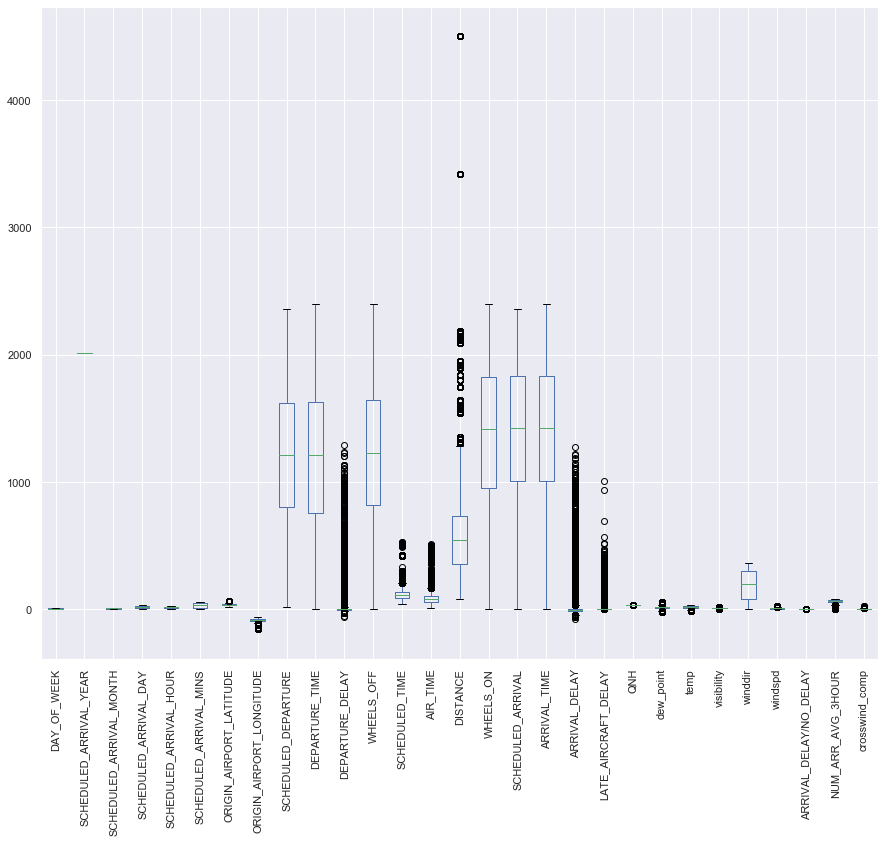

In [30]:
plt.figure(figsize=(15,12))
df.boxplot()
plt.xticks(rotation=90);

**(ii) Visual inspection of numerical features and their relation with ARRIVAL_DELAY**

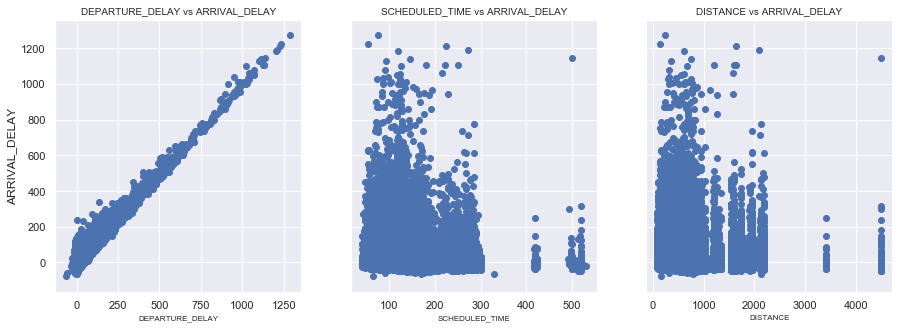

In [31]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True)

ax[0].scatter(df['DEPARTURE_DELAY'], df['ARRIVAL_DELAY'])
ax[0].set_title('DEPARTURE_DELAY vs ARRIVAL_DELAY', fontsize=10)
ax[0].set_xlabel('DEPARTURE_DELAY', fontsize=8)
ax[0].set_ylabel('ARRIVAL_DELAY')

ax[1].scatter(df['SCHEDULED_TIME'], df['ARRIVAL_DELAY'])
ax[1].set_title('SCHEDULED_TIME vs ARRIVAL_DELAY', fontsize=10)
ax[1].set_xlabel('SCHEDULED_TIME', fontsize=8)

ax[2].scatter(df['DISTANCE'], df['ARRIVAL_DELAY'])
ax[2].set_title('DISTANCE vs ARRIVAL_DELAY', fontsize=10)
ax[2].set_xlabel('DISTANCE', fontsize=8);

The first plot above seem to suggest that departure delays will have subsequent linear impact on the arrival delays.

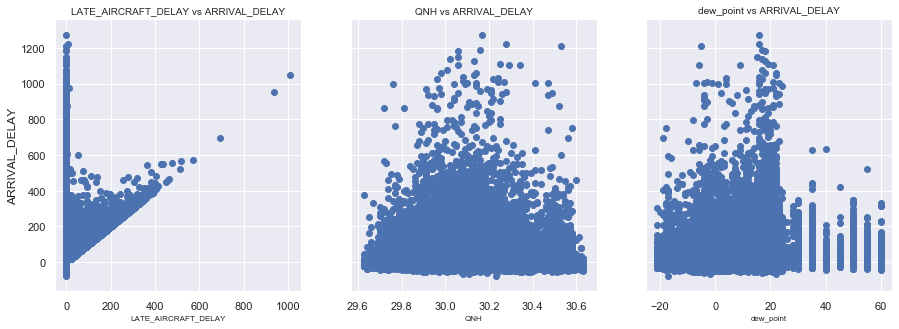

In [32]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True)

ax[0].scatter(df['LATE_AIRCRAFT_DELAY'], df['ARRIVAL_DELAY'])
ax[0].set_title('LATE_AIRCRAFT_DELAY vs ARRIVAL_DELAY', fontsize=10)
ax[0].set_xlabel('LATE_AIRCRAFT_DELAY', fontsize=8)
ax[0].set_ylabel('ARRIVAL_DELAY')

ax[1].scatter(df['QNH'], df['ARRIVAL_DELAY'])
ax[1].set_title('QNH vs ARRIVAL_DELAY', fontsize=10)
ax[1].set_xlabel('QNH', fontsize=8)

ax[2].scatter(df['dew_point'], df['ARRIVAL_DELAY'])
ax[2].set_title('dew_point vs ARRIVAL_DELAY', fontsize=10)
ax[2].set_xlabel('dew_point', fontsize=8);

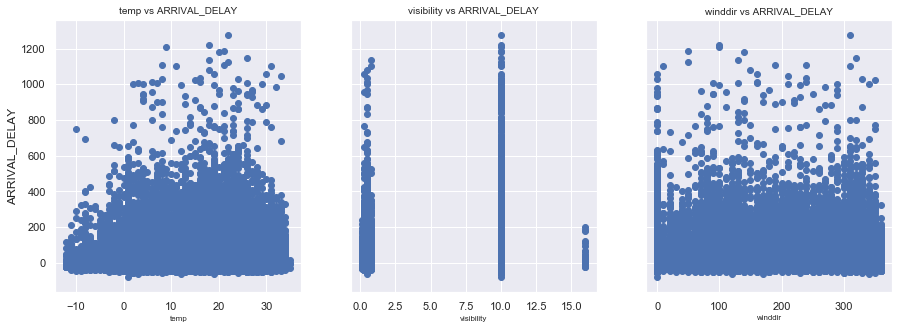

In [33]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True)

ax[0].scatter(df['temp'], df['ARRIVAL_DELAY'])
ax[0].set_title('temp vs ARRIVAL_DELAY', fontsize=10)
ax[0].set_xlabel('temp', fontsize=8)
ax[0].set_ylabel('ARRIVAL_DELAY')

ax[1].scatter(df['visibility'], df['ARRIVAL_DELAY'])
ax[1].set_title('visibility vs ARRIVAL_DELAY', fontsize=10)
ax[1].set_xlabel('visibility', fontsize=8)

ax[2].scatter(df['winddir'], df['ARRIVAL_DELAY'])
ax[2].set_title('winddir vs ARRIVAL_DELAY', fontsize=10)
ax[2].set_xlabel('winddir', fontsize=8);

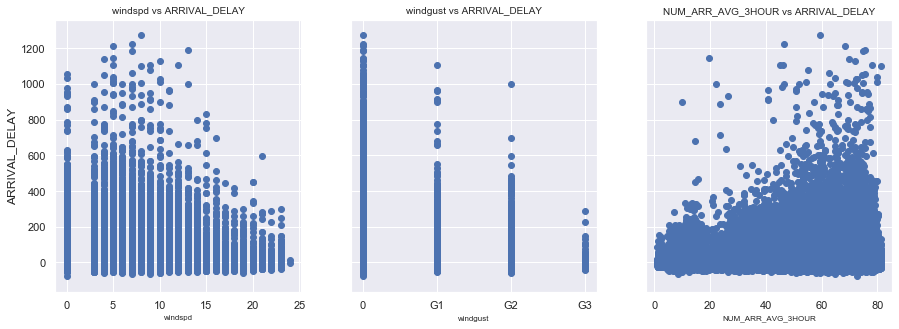

In [34]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True)

ax[0].scatter(df['windspd'], df['ARRIVAL_DELAY'])
ax[0].set_title('windspd vs ARRIVAL_DELAY', fontsize=10)
ax[0].set_xlabel('windspd', fontsize=8)
ax[0].set_ylabel('ARRIVAL_DELAY')

ax[1].scatter(df['windgust'], df['ARRIVAL_DELAY'])
ax[1].set_title('windgust vs ARRIVAL_DELAY', fontsize=10)
ax[1].set_xlabel('windgust', fontsize=8)

ax[2].scatter(df['NUM_ARR_AVG_3HOUR'], df['ARRIVAL_DELAY'])
ax[2].set_title('NUM_ARR_AVG_3HOUR vs ARRIVAL_DELAY', fontsize=10)
ax[2].set_xlabel('NUM_ARR_AVG_3HOUR', fontsize=8);

_See **(viii) Checking if our created NUM_ARR_AVG_3HOUR feature has any impact on delays**_

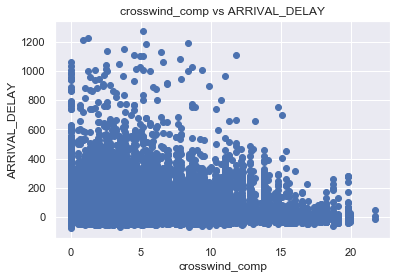

In [35]:
plt.scatter(df['crosswind_comp'], df['ARRIVAL_DELAY'])
plt.title('crosswind_comp vs ARRIVAL_DELAY', fontsize=12)
plt.xlabel('crosswind_comp')
plt.ylabel('ARRIVAL_DELAY');

_See **(ix) Arrival Delay by Crosswind Component**_

**(iii) Flights into KATL**

In [36]:
df.ORIGIN_COUNTRY.unique() # All domestic flights (as already mentioned in the dataset description)

# international flights make up about 10% of all flights in KATL

array(['USA'], dtype=object)

The dataset is only comprising of domestic flights within the US as shown above. Now this poses an issue that the NUM_ARR_IN_HOUR feature will not capture the actual number of flights scheduled to arrive in that hour (due to missing international flight data)

There are 2 ways which I think can help alleviate this issue for now:

1. We continue using only the domestic flight data and we assume that the machine will adjust its weights accordingly to the scaled inputs (to simply capture the impact of the changes in magnitude)
2. We scale up the data by the portion of flights every month (i.e. if Jan is 90% domestic & 10% international flights, we take every entry in Jan and increase the count by 10%) and we assume that the increment due to international flights is equally distributed across the day.

For the purpose of simplicity, we will take the first approach for this project

In [37]:
len(df.ORIGIN_STATE.unique())

50

In [38]:
len(df.ORIGIN_CITY.unique())

158

In [39]:
len(df.ORIGIN_AIRPORT.unique())

168

Total of:
1. 50 domestic states
2. 158 domestic cities
3. 168 domestics airports

Flying into Atlanta Airport

**(iv) Arrival Delays by Airlines**

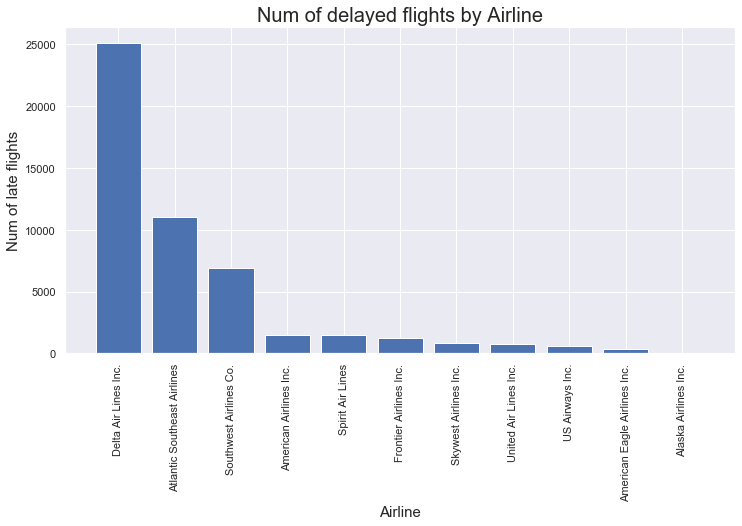

In [40]:
plt.figure(figsize=(12,6))
plt.bar(df.groupby('AIRLINE_NAME')['ARRIVAL_DELAY/NO_DELAY'].sum().sort_values(ascending=False).index, df.groupby('AIRLINE_CODE')['ARRIVAL_DELAY/NO_DELAY'].sum().sort_values(ascending=False))
plt.ylabel('Num of late flights', fontsize=15)
plt.xlabel('Airline', fontsize=15)
plt.title('Num of delayed flights by Airline', fontsize=20)
plt.xticks(rotation=90);

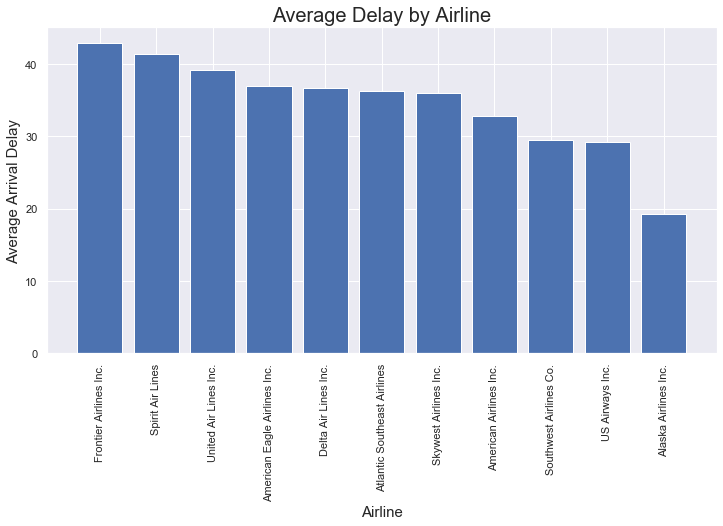

In [42]:
plt.figure(figsize=(12,6))

# Notice [df['ARRIVAL_DELAY']>0] in the plot below, we do not want the flights which arrived early to skew the average delays

plt.bar(df[df['ARRIVAL_DELAY']>0].groupby('AIRLINE_NAME')['ARRIVAL_DELAY'].mean().sort_values(ascending=False).index, df[df['ARRIVAL_DELAY']>0].groupby('AIRLINE_CODE')['ARRIVAL_DELAY'].mean().sort_values(ascending=False))
plt.ylabel('Average Arrival Delay', fontsize=15)
plt.xlabel('Airline', fontsize=15)
plt.title('Average Delay by Airline', fontsize=20)
plt.xticks(rotation=90);

Whilst Delta Air accounts for the most number of domestic delayed flights, Frontier Airlines is the one which has the highest average delay per flight.

**(v) Arrival Delay by Origin Airport**

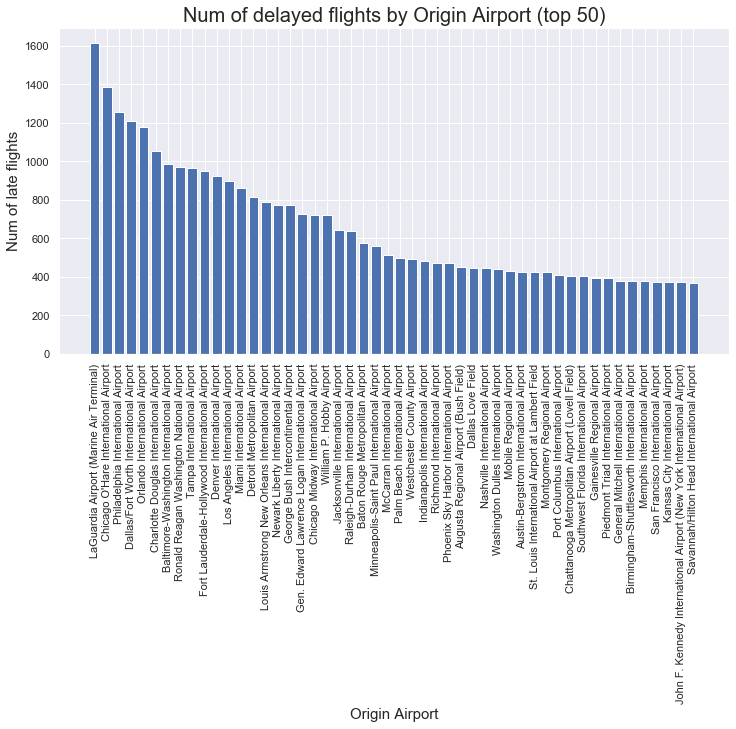

In [44]:
plt.figure(figsize=(12,6))
plt.bar(df.groupby('ORIGIN_AIRPORT_NAME')['ARRIVAL_DELAY/NO_DELAY'].sum().sort_values(ascending=False)[:50].index, df.groupby('ORIGIN_AIRPORT_NAME')['ARRIVAL_DELAY/NO_DELAY'].sum().sort_values(ascending=False)[:50])
plt.ylabel('Num of late flights', fontsize=15)
plt.xlabel('Origin Airport', fontsize=15)
plt.title('Num of delayed flights by Origin Airport (top 50)', fontsize=20)
plt.xticks(rotation=90);

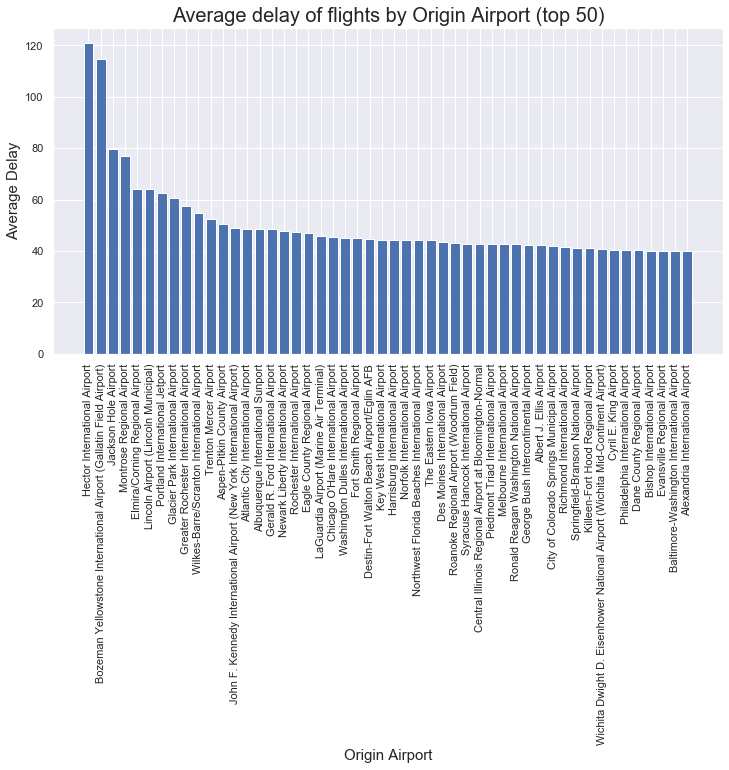

In [45]:
plt.figure(figsize=(12,6))

# Notice [df['ARRIVAL_DELAY']>0] in the plot below, we do not want the flights which arrived early to skew the average delays
plt.bar(df[df['ARRIVAL_DELAY']>0].groupby('ORIGIN_AIRPORT_NAME')['ARRIVAL_DELAY'].mean().sort_values(ascending=False)[:50].index, df[df['ARRIVAL_DELAY']>0].groupby('ORIGIN_AIRPORT_NAME')['ARRIVAL_DELAY'].mean().sort_values(ascending=False)[:50])
plt.ylabel('Average Delay', fontsize=15)
plt.xlabel('Origin Airport', fontsize=15)
plt.title('Average delay of flights by Origin Airport (top 50)', fontsize=20)
plt.xticks(rotation=90);

Whilst LaGuarda Airport accounts for the most number of domestic delayed flights, Hector International Airport is the one which accounts for the highest average delay per flight.

**(vi) Arrival Delay by Distance Apart _(of the 2 airports)_**

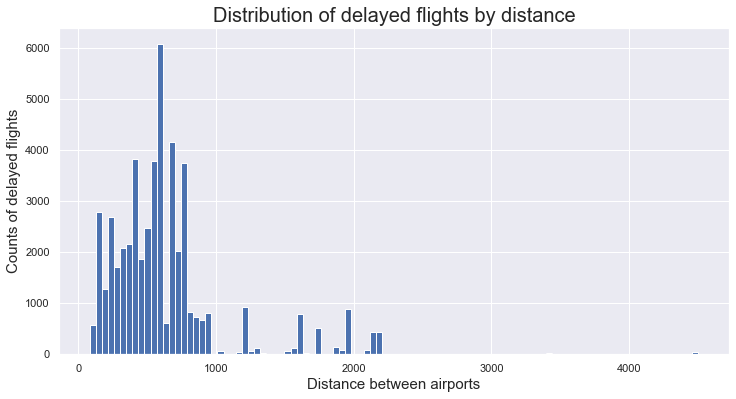

In [47]:
plt.figure(figsize=(12,6))
plt.hist(df[df['ARRIVAL_DELAY/NO_DELAY']==1]['DISTANCE'], bins=100)
plt.xlabel('Distance between airports', fontsize=15)
plt.ylabel('Counts of delayed flights', fontsize=15)
plt.title('Distribution of delayed flights by distance', fontsize=20);

**(vii) Arrival Delay by Late Aircraft Arrivals**

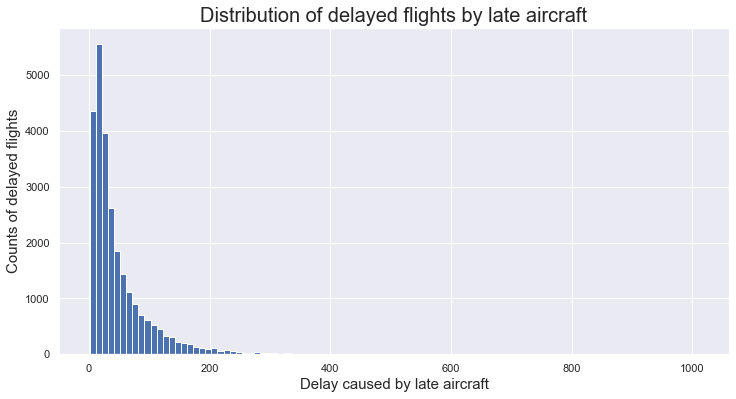

In [49]:
plt.figure(figsize=(12,6))

# df['LATE_AIRCRAFT_DELAY']>0 essentially sieves out aircrafts which ARE impacted by late aircrafts
plt.hist(df[(df['ARRIVAL_DELAY/NO_DELAY']==1) & (df['LATE_AIRCRAFT_DELAY']>0)]['LATE_AIRCRAFT_DELAY'], bins=100)
plt.xlabel('Delay caused by late aircraft', fontsize=15)
plt.ylabel('Counts of delayed flights', fontsize=15)
plt.title('Distribution of delayed flights by late aircraft', fontsize=20);

**(viii) Checking if our created NUM_ARR_AVG_3HOUR feature has any impact on delays**

In [53]:
from sklearn.feature_selection import f_classif

In [54]:
# Checking if the means of the number of arrivals averaged in 3 hour window differ for delayed and not delayed aircrafts
f_classif(df[['NUM_ARR_AVG_3HOUR']], df['ARRIVAL_DELAY/NO_DELAY'])

(array([353.66414493]), array([7.3985856e-79]))

The p-value for the ANOVA test is <0.05 and as such we reject the null hypothesis that the means of the number of arrivals averaged in a 3 hour window is the same.

_The number of arrivals in a 3 hour window feature has an impact on whether a flight will be delayed._

**(ix) Arrival Delay by Crosswind Component**

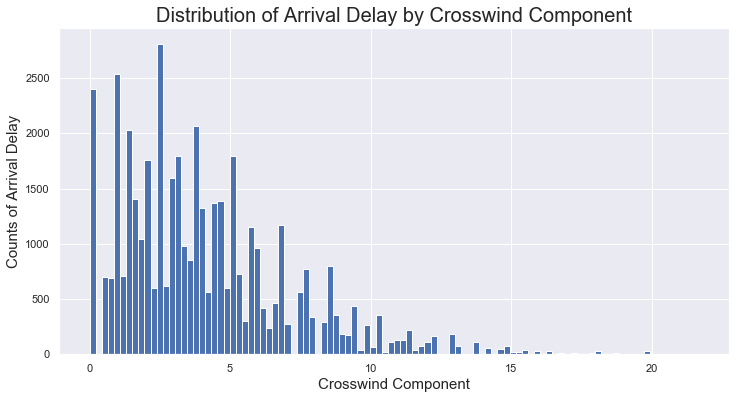

In [56]:
plt.figure(figsize=(12,6))
plt.hist(df[(df['ARRIVAL_DELAY/NO_DELAY']==1) & (df['crosswind_comp']>0)]['crosswind_comp'], bins=100)
plt.xlabel('Crosswind Component', fontsize=15)
plt.ylabel('Counts of Arrival Delay', fontsize=15)
plt.title('Distribution of Arrival Delay by Crosswind Component', fontsize=20);

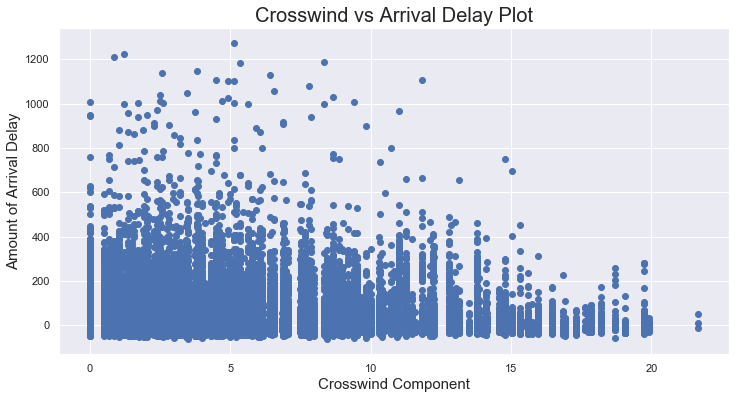

In [57]:
plt.figure(figsize=(12,6))
plt.scatter(df[(df['crosswind_comp']>0)]['crosswind_comp'], df[(df['crosswind_comp']>0)]['ARRIVAL_DELAY'])
plt.xlabel('Crosswind Component', fontsize=15)
plt.ylabel('Amount of Arrival Delay', fontsize=15)
plt.title('Crosswind vs Arrival Delay Plot', fontsize=20);

As we look at the chart, we might think that high crosswinds have lesser impact on delaying a flight. On the contrary, based on my experience as an Air Traffic Controller, this is not the case. When the crosswinds are very high/extreme (maybe in the ranges above 5kts) aircrafts might choose to hold and wait out the weather instead of attempting to land. And this might not be reflected in the 'Amount of Arrival Delay' above as the amount of arrival delay could be dominantly influenced by other factors. _(i.e. Even tho it seems that the higher delays of 1200 mins seem to be in the 5kts range, it could be due to other factors like late aircraft delays, etc; and these factors dominate outcome over the impact of crosswind component)_

At most airports, crosswinds above 35kts prohibit landings and take off. Based on experience, at wind speeds above 25kts you will start seeing minor delays, depending on airport configuration and aircraft type.  At around 40kts the delays will start becoming significant.

As such crosswinds do play a role in causing delays, despite how the plot above looks like. 

---
### (4) Dropping anomalies

---

Per ICAO Annex 6, Part I, section 4.3.6 "Fuel Requirements," airplanes should calculate their required fuel quantity as follows (summary; see below for actual ICAO text):

1. Taxi fuel
2. Trip fuel (to reach intended destination)
3. Contingency fuel (higher of 5% of "trip fuel" or 5 minutes of holding flight)
4. Destination alternate fuel (to fly a missed and reach an alternate)
5. Final reserve fuel (45 minutes of holding flight for reciprocating engines, 30 minutes for jets)
6. Additional fuel (if needed to guarantee ability to reach an alternate with an engine failure or at lower altitude due to a pressurization loss)
7. Discretionary fuel (if the pilot in command wants it)

From our dataset, we have _scheduled time_ and _actual airtime_. Assuming the fuel consumption is constant to flight time, our _scheduled time_ is actually our taxi fuel & trip fuel.

Our contingency fuel would translate to about extra 5 minutes.

A safe estimate (that all diverted flights would hold enough fuel to the furthest diversion aerodrome, Knoxvile Airport), would be that the contingency fuel would be an average of 31 minutes (we will take 40 minutes to try and capture the upper limit)

Additional reserve fuel would lead to an extra 30 mins of flight time (but we would not include this as usually by this time, the flight would likely have been calling for a fuel emergency)

We shall ignore discresionary fuel for the unpredictable nature of it.

**So for a flight of X hours _(scheduled time)_ we would expect the flight to be capable of being delayed for (before havin to divert or call for fuel emergency):**

    X + 5 + 40 + 30mins
    
**Hence if a flight's _actual airtime_ is greater than this delay timing, we would categorize it as an anomaly and drop it**

---

In [58]:
# Dropping the "anomalies"

df = df[(df['AIR_TIME']-(df['SCHEDULED_TIME'] + 5 + 30)<0)]

---
### (5) Exporting the dataset

Exporting the dataset for feature engineering & selection

---

In [59]:
df.head()

,DATETIME,DAY_OF_WEEK,SCHEDULED_ARRIVAL_YEAR,SCHEDULED_ARRIVAL_MONTH,SCHEDULED_ARRIVAL_DAY,SCHEDULED_ARRIVAL_HOUR,SCHEDULED_ARRIVAL_MINS,AIRLINE_CODE,AIRLINE_NAME,ORIGIN_AIRPORT,ORIGIN_AIRPORT_NAME,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_AIRPORT_LATITUDE,ORIGIN_AIRPORT_LONGITUDE,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,WHEELS_OFF,SCHEDULED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,LATE_AIRCRAFT_DELAY,QNH,dew_point,lightning,low_intensity,rain,shower,snow,squall,temp,thunderyshower,vicinity,visibility,winddir,windspd,windgust,ARRIVAL_DELAY/NO_DELAY,NUM_ARR_AVG_3HOUR,crosswind_comp
0,2015-01-01,4,2015,1,1,7,11,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,30,33.0,3.0,45.0,221.0,186.0,1747,651.0,711,656.0,-15.0,0.0,30.36,0.0,0,0,0,0,0,0,4.0,0,0,10.0,0.0,0.0,0,0,20.000000,0.000000
1,2015-01-01,4,2015,1,1,14,0,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,715,712.0,-3.0,726.0,225.0,191.0,1747,1337.0,1400,1342.0,-18.0,0.0,30.31,-3.0,0,0,0,0,0,0,1.0,0,0,10.0,330.0,7.0,0,0,57.000000,6.062178
2,2015-01-01,4,2015,1,1,17,58,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,1115,1116.0,1.0,1131.0,223.0,191.0,1747,1742.0,1758,1747.0,-11.0,0.0,30.33,-3.0,0,0,0,0,0,0,0.0,0,0,10.0,0.0,0.0,0,0,51.666667,0.000000
3,2015-01-01,4,2015,1,1,20,33,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,1345,1353.0,8.0,1406.0,228.0,194.0,1747,2020.0,2033,2023.0,-10.0,0.0,30.36,-3.0,0,0,0,0,0,0,8.0,0,0,10.0,310.0,4.0,0,0,43.666667,2.571150
4,2015-01-01,4,2015,1,1,22,0,DL,Delta Air Lines Inc.,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,ATL,1519,1518.0,-1.0,1530.0,221.0,190.0,1747,2140.0,2200,2144.0,-16.0,0.0,30.28,-6.0,0,0,0,0,0,0,12.0,0,0,10.0,260.0,3.0,0,0,13.000000,0.520945


In [60]:
df.to_csv('../datasets/combined_data_feature_selection.csv', index=False)